### Datasets preprocessing:

Datasets that need some preprocessing before they can be used in `TruBenchmarkExperiment` class:
1. Snowflake IT (internal): both rephrased and regular?, this should be used for all 3 in the triad
2. SummEval (CNN and DailyMail summarizations with annotation) for groundedness
3. QAGS (CNN and DailyMail with Turkers' annotation) for groundedness
4. QAGS (XSUM with Turkers' annotation) for groundedness
5. MSMARCO V2 for context relevance
6. HotPot QA for answer relevance 



In [2]:
import ast
import csv
import json
import random

import pandas as pd

# Pin random seed
random.seed(42)


# SummEval
def generate_summeval_groundedness_golden_set(file_path):
    def calculate_expected_score(normalized_metrics_lst, weights_lst):
        assert len(normalized_metrics_lst) == len(weights_lst)
        return round(
            sum(
                normalized_metrics_lst[i] * weights_lst[i]
                for i in range(len(normalized_metrics_lst))
            )
            / sum(weights_lst),
            2,
        )

    with open(file_path) as f:
        for line in f:
            # Each line is a separate JSON object
            try:
                data = json.loads(line)

                # Ensure the expected keys exist in the JSON
                try:
                    row = data
                    assert (
                        len(row["machine_summaries"]) == len(row["consistency"])
                    ), "Mismatch in lengths of machine_summaries and consistency"

                    # Iterate over the summaries and create the desired dictionary structure
                    for i in range(len(row["machine_summaries"])):
                        yield {
                            "query": row.get(
                                "text", ""
                            ),  # Default to empty string if key not found
                            "expected_response": row["machine_summaries"][i],
                            "expected_score": calculate_expected_score(
                                [
                                    (row["consistency"][i] - 1)
                                    / 4,  # Normalize from [1, 5] to [0, 1]
                                ],
                                [1.0],
                            ),
                            "human_score": row["consistency"][i],
                        }

                except KeyError as e:
                    print(
                        f"Key error: {e}. Please check if the keys exist in the JSON file."
                    )
                except AssertionError as e:
                    print(
                        f"Assertion error: {e}. The lengths of 'machine_summaries' and 'consistency' do not match."
                    )

            except json.JSONDecodeError as e:
                print(f"JSON decode error: {e}. Check the line format.")


# Snowflake IT dataset


def generatate_snowflake_it_golden_set_groundedness(file_path):
    res = []
    with open(file_path, mode="r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        all_rows = list(reader)
        for row in all_rows:
            # Convert the 'golden' from a string to a list
            try:
                expected_chunks = ast.literal_eval(row["golden"])
                if not isinstance(expected_chunks, list):
                    raise ValueError("Golden column should be a list")

                for expected_chunk in expected_chunks:
                    # Yield the required fields
                    res.append({
                        "query": expected_chunk,  # source
                        "expected_response": row[
                            "expected_response"
                        ],  # statement
                        "expected_score": 1,  # retrieved chunks in the "golden" colum are always considered grounded
                    })

                # Generate a negative example for each query
                # Collect all possible chunks from other queries to use as negative contexts
                other_chunks = [
                    chunk
                    for other_row in all_rows
                    if other_row != row
                    for chunk in ast.literal_eval(other_row["golden"])
                ]

                # Randomly select a negative chunk (context from another query)
                if other_chunks:
                    negative_chunk = random.choice(other_chunks)
                    res.append({
                        "query": negative_chunk,
                        "expected_response": row[
                            "expected_response"
                        ],  # statement (not grounded by the chunk)
                        "expected_score": 0,  # Negative example, score = 0
                    })

            except (ValueError, SyntaxError) as e:
                print(f"Error parsing golden column: {e}")
                continue

    return res


def generate_snowflake_it_golden_set_answer_relevance(file_path):
    res = []
    with open(file_path, mode="r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        all_rows = list(
            reader
        )  # Store all rows in memory to use for negative example generation

        for row in all_rows:
            # generate a positive example for each query
            if (
                "I don’t know the answer to that question."
                in row["expected_response"]
            ):
                ground_truth_score = 0  # label answer relevance as 0 for ABSTENTION "I don’t know the answer to that question."
            else:
                ground_truth_score = (
                    1  # label answer relevance as 1 for all other cases
                )
            res.append({
                "query": row["query"],
                "expected_response": row["expected_response"],
                "expected_score": ground_truth_score,
            })

            # generate an easy negative example for each positive example by randomly selecting a response from another query
            negative_response = random.choice([
                r["expected_response"] for r in all_rows if r != row
            ])
            res.append({
                "query": row["query"],
                "expected_response": negative_response,  # Orthogonal response
                "expected_score": 0,  # Label answer relevance as 0 for negative examples
            })

    return res


def generate_snowflake_it_golden_set_context_relevance(file_path):
    res = []
    with open(file_path, mode="r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        all_rows = list(reader)

        # Step 1: Process each row to extract positive examples
        for row in all_rows:
            try:
                expected_chunks = ast.literal_eval(row["golden"])

                if not isinstance(expected_chunks, list):
                    raise ValueError("Golden column should be a list")

                # Generate positive examples
                for expected_chunk in expected_chunks:
                    res.append({
                        "query": row["query"],
                        "expected_response": expected_chunk,
                        "expected_score": 1,  # Positive example, score = 1
                    })

                # Step 2: Generate a negative example for each query
                # Collect all possible chunks from other queries to use as negative contexts
                other_chunks = [
                    chunk
                    for other_row in all_rows
                    if other_row != row
                    for chunk in ast.literal_eval(other_row["golden"])
                ]

                # Randomly select a negative chunk (context from another query)
                if other_chunks:
                    negative_chunk = random.choice(other_chunks)
                    res.append({
                        "query": row["query"],
                        "expected_response": negative_chunk,  # Orthogonal/negative context
                        "expected_score": 0,  # Negative example, score = 0
                    })

            except (ValueError, SyntaxError) as e:
                print(
                    f"Error parsing golden column for query '{row['query']}': {e}"
                )
                continue

        return res


def generate_qags_golden_set_groundedness(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            # Parse each line as a JSON object
            data = json.loads(line)

            # Extract the article as the query
            query = data["article"]

            # Iterate over the summary_sentences to flatten the structure
            for summary in data["summary_sentences"]:
                expected_response = summary["sentence"]

                # Calculate expected_score based on worker responses
                responses = [
                    response["response"] for response in summary["responses"]
                ]
                # Convert 'yes' to 1 and 'no' to 0, then calculate the average
                expected_score = sum(
                    1 if r.lower() == "yes" else 0 for r in responses
                ) / len(responses)

                # Yield the processed record
                yield {
                    "query": query,
                    "expected_response": expected_response,
                    "expected_score": expected_score,
                }


snowflake_it_file_path = "/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/data/snowflake_it_v3.csv"

snowflake_it_for_answer_relevance = pd.DataFrame(
    list(
        generate_snowflake_it_golden_set_answer_relevance(
            snowflake_it_file_path
        )
    )
)
snowflake_it_answer_relevance_true_labels = list(
    snowflake_it_for_answer_relevance["expected_score"]
)

snowflake_it_for_context_relevance = pd.DataFrame(
    list(
        generate_snowflake_it_golden_set_context_relevance(
            snowflake_it_file_path
        )
    )
)
snowflake_it_for_context_relevance_true_labels = list(
    snowflake_it_for_context_relevance["expected_score"]
)


snowflake_it_for_groundness = pd.DataFrame(
    list(
        generatate_snowflake_it_golden_set_groundedness(snowflake_it_file_path)
    )
)
snowflake_it_for_groundness_true_labels = list(
    snowflake_it_for_groundness["expected_score"]
)

summeval_list = list(
    generate_summeval_groundedness_golden_set(
        "/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/data/summeval_test.json"
    )
)

summeval_true_labels = [entry["expected_score"] for entry in summeval_list]

summeval = pd.DataFrame(
    list(
        generate_summeval_groundedness_golden_set(
            "/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/data/summeval_test.json"
        )
    )
)

qags_cnn_dm = pd.DataFrame(
    list(
        generate_qags_golden_set_groundedness(
            "/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/data/qags_mturk_cnndm.jsonl"
        )
    )
)

qags_cnn_dm_true_labels = [
    row["expected_score"] for _, row in qags_cnn_dm.iterrows()
]


qags_xsum = pd.DataFrame(
    list(
        generate_qags_golden_set_groundedness(
            "/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/data/qags_mturk_xsum.jsonl"
        )
    )
)

qqags_xsum_true_labels = [
    row["expected_score"] for _, row in qags_xsum.iterrows()
]

In [ ]:
# random.seed(42)

# from datasets import load_dataset

# ds = load_dataset("nixiesearch/ms-marco-hard-negatives")
# ms_marco_hard_neg = pd.DataFrame(ds)


In [33]:
random.seed(42)

def generate_balanced_ms_marco_hard_negatives_dataset(series: pd.Series, sample_size: int = 400):
    # sampled_series = series.sample(n=sample_size, random_state=42)
    sampled_series = series[:sample_size]    
    # Step 2: Create a list for the balanced dataset
    balanced_dataset = []
    
    # Step 3: Iterate over the sampled rows
    for idx, row in sampled_series.items():
        # "row" is a dictionary containing 'query', 'positive', and 'negative'
        query = row.get("query")
        positive_list = row.get("positive", [])
        negative_list = row.get("negative", [])
        print(f'query: {query}')
        # Select one positive example
        if positive_list:
            positive_example = random.choice(positive_list)
        else:
            continue  # Skip if no positive examples
        
        # Select one negative example
        if negative_list:
            negative_example = random.choice(negative_list)
        else:
            continue  # Skip if no negative examples
        
        print(f'positive_example: {positive_example} \n negative_example: {negative_example}')
        # Add a positive example to the dataset
        balanced_dataset.append({
            "query": query,
            "expected_response": positive_example,
            "expected_score": 1  # Positive example, label 1
        })

        # Add a negative example to the dataset
        balanced_dataset.append({
            "query": query,
            "expected_response": negative_example,
            "expected_score": 0  # Negative example, label 0
        })
    
    # Ensure the dataset is exactly 200 positive and 200 negative examples
    balanced_dataset = balanced_dataset[:sample_size]  # Ensure total sample size is respected
    
    # Convert the list to a DataFrame for convenience
    balanced_df = pd.DataFrame(balanced_dataset)
    
    return balanced_df

In [7]:
# ms_marco_hard_neg_balanced = generate_balanced_ms_marco_hard_negatives_dataset(ms_marco_hard_neg['train'], 400)
# ms_marco_hard_neg_balanced.to_csv("ms_marco_hard_neg_balanced.csv", index=False)
ms_marco_hard_neg_balanced = pd.read_csv("ms_marco_hard_neg_balanced.csv")
ms_marco_hard_neg_balanced

,query,expected_response,expected_score
0,)what was the immediate impact of the success ...,The presence of communication amid scientific ...,1
1,)what was the immediate impact of the success ...,The pivotal engineering and scientific success...,0
2,_________ justice is designed to repair the ha...,The approach is based on a theory of justice t...,1
3,_________ justice is designed to repair the ha...,Retributive justice is a theory of justice whi...,0
4,what color is amber urine,"Colorâurine can be a variety of colors, most...",1
...,...,...,...
395,how much does it cost to replace a foundation ...,the average cost of a foundation repair the av...,0
396,what is glycohemoglobin,test overview a glycohemoglobin test or hemogl...,1
397,what is glycohemoglobin,"The hemoglobin A1c test, also called HbA1c, gl...",0
398,stalactites definition,A stalagmite (UK /ËstaelÉÉ¡maÉªt/ ËstÃ¦lÉÉ...,1


In [37]:
random.seed(42)


def generate_ms_marco_context_relevance_benchmark(
    file_path="/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/data/ms_marco_v2_1_val.parquet",
):
    df = pd.read_parquet(file_path, engine="pyarrow")  # or engine='fastparquet'

    for _, row in df.iterrows():
        assert len(row["passages"]["is_selected"]) == len(
            row["passages"]["passage_text"]
        )

        if sum(row["passages"]["is_selected"]) < 1:
            # currently we only consider sample with one passage marked as relevant (there are samples where zero passage_text is selected)
            continue
        for i, passage_text in enumerate(row["passages"]["passage_text"]):
            yield {
                "query_id": row["query_id"],
                "query": row["query"],
                "expected_response": passage_text,
                "expected_score": row["passages"]["is_selected"][
                    i
                ],  # Binary relevance
            }


ms_marco = list(generate_ms_marco_context_relevance_benchmark())


score_1_entries = [entry for entry in ms_marco if entry["expected_score"] == 1]
score_0_entries = [entry for entry in ms_marco if entry["expected_score"] == 0]

# Calculate the number of samples needed from each group
num_samples_per_group = min(
    len(score_1_entries), len(score_0_entries), 150
)  # Sample 150 from each


sampled_score_1 = random.sample(score_1_entries, num_samples_per_group)
sampled_score_0 = random.sample(score_0_entries, num_samples_per_group)

# Combine and shuffle the samples to get a balanced dataset
balanced_sample = sampled_score_1 + sampled_score_0
random.shuffle(balanced_sample)

# Ensure the combined length is 300
assert len(balanced_sample) == 300

# Now you can use `balanced_sample` as your final dataset
print(
    f"Number of entries with expected_score = 1: {len([e for e in balanced_sample if e['expected_score'] == 1])}"
)
print(
    f"Number of entries with expected_score = 0: {len([e for e in balanced_sample if e['expected_score'] == 0])}"
)

ms_marco_balanced_sample_300 = pd.DataFrame(balanced_sample)

Number of entries with expected_score = 1: 150
Number of entries with expected_score = 0: 150


In [38]:
ms_marco_balanced_sample_300

,query_id,query,expected_response,expected_score
0,429239,is there poison ivy in oregon,Poison oak is common to western Oregon and Was...,1
1,632923,what does bbb rating mean for a bond,Definition of Baa3 Rating in the Financial Dic...,0
2,151780,direct material price variance formula,Direct Material Price Variance: = Actual Quant...,1
3,1028902,what is vesd,"VESDA is a laser based smoke detector, which m...",1
4,993874,which of the following planets has the shortes...,Neptune has the longest year( Pluto would be b...,0
...,...,...,...,...
295,1040065,what is the elevation of orlando,Elevation: 106 feet. Land area: 93.5 square mi...,0
296,695081,what is a plateau period,pla•teau. 1. a land area having a relatively l...,1
297,728820,what is cease fire mean,"A ceasefire (or truce), also called cease fire...",1
298,427635,is the tv show lucifer renewed,FOX Renewed TV Series Lucifer for Second Seaso...,1


### Load preprocessed datasets from BEIR - start w/ Hotpot QA 

In [ ]:
from trulens.benchmark.benchmark_frameworks.dataset.beir_loader import (
    TruBEIRDataLoader,
)

beir_data_loader = TruBEIRDataLoader(data_folder="./", dataset_name="hotpotqa")
hotpotqa = beir_data_loader.load_dataset_to_df(download=True)

In [ ]:
random.seed(42)


hotpotqa_raw_subset = hotpotqa.sample(n=200, random_state=42)

all_responses = [
    (row["query"], row["expected_response"])
    for idx, row in hotpotqa_raw_subset.iterrows()
]

all_contexts = [
    (row["query"], context["text"])
    for idx, row in hotpotqa_raw_subset.iterrows()
    for context in row["expected_chunks"]
]

hotpotqa_subset_for_answer_relevance, hotpotqa_subset_for_context_relevance = (
    [],
    [],
)


for idx, row in hotpotqa_raw_subset.iterrows():
    # Positive examples for answer relevance
    hotpotqa_subset_for_answer_relevance.append({
        "query": row["query"],
        "expected_response": row["expected_response"],  # Positive response
        "expected_score": 1,  # Positive example, score = 1
    })

    # Negative examples for answer relevance (random unrelated response)
    negative_response = random.choice([
        r
        for q, r in all_responses
        if q != row["query"]  # Pick response from another query
    ])

    hotpotqa_subset_for_answer_relevance.append({
        "query": row["query"],
        "expected_response": negative_response,  # Negative response
        "expected_score": 0,  # Negative example, score = 0
    })


for idx, row in hotpotqa_raw_subset.iterrows():
    positive_examples = []
    negative_examples = []

    # Generate positive examples for context relevance
    for context in row["expected_chunks"]:
        positive_examples.append({
            "query": row["query"],
            "expected_response": context["text"],  # Positive context
            "expected_score": context["expected_score"],  # Should be 1
        })

    # Generate negative examples for context relevance
    for _ in positive_examples:
        negative_context = random.choice([
            c
            for q, c in all_contexts
            if q != row["query"]  # Pick context from another query
        ])
        negative_examples.append({
            "query": row["query"],
            "expected_response": negative_context,  # Negative context
            "expected_score": 0,  # Negative example, score = 0
        })

    # Add positive and negative examples to the result set
    hotpotqa_subset_for_context_relevance.extend(positive_examples)
    hotpotqa_subset_for_context_relevance.extend(negative_examples)


hotpotqa_subset_for_context_relevance_true_labels = [
    entry["expected_score"] for entry in hotpotqa_subset_for_context_relevance
]
hotpotqa_subset_for_answer_relevance_true_labels = [
    entry["expected_score"] for entry in hotpotqa_subset_for_answer_relevance
]

hotpotqa_subset_for_context_relevance = pd.DataFrame(
    hotpotqa_subset_for_context_relevance
)

hotpotqa_subset_for_answer_relevance = pd.DataFrame(
    hotpotqa_subset_for_answer_relevance
)

In [ ]:
hotpotqa_subset_for_context_relevance

In [ ]:
summeval_subset = summeval.sample(n=200, random_state=42)
summeval_subset_true_labels = [
    row["expected_score"] for _, row in summeval_subset.iterrows()
]

### Set up feedback LLM providers 

We will experiment with 2 current OpenAI models and a mix of commercial and open source models avaiable in Cortex

In [1]:
import os

import snowflake.connector
from trulens.providers.cortex import Cortex
from trulens.providers.openai import OpenAI

snowflake_connection_parameters = {
    "account": os.environ["SNOWFLAKE_ACCOUNT"],
    "user": os.environ["SNOWFLAKE_USER"],
    "password": os.environ["SNOWFLAKE_USER_PASSWORD"],
}
snowflake_connection = snowflake.connector.connect(
    **snowflake_connection_parameters
)


gpt_4o = OpenAI(model_engine="gpt-4o")
gpt_4o_mini = OpenAI(model_engine="gpt-4o-mini")

snowflake_arctic = Cortex(snowflake_connection, model_engine="snowflake-arctic")
mistral_large = Cortex(snowflake_connection, model_engine="mistral-large")
llama3_1_8b = Cortex(snowflake_connection, model_engine="llama3.1-8b")

CORTEX_PROVIDERS = [snowflake_arctic, llama3_1_8b, mistral_large]
OPENAI_PROVIDERS = [gpt_4o, gpt_4o_mini]
ALL_PROVIDERS = CORTEX_PROVIDERS + OPENAI_PROVIDERS

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /opt/anaconda3/envs/trulens/lib/python3.11/site-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
from trulens.core import TruSession

session = TruSession()
session.reset_database()

🦑 TruSession initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.


Updating app_name and app_version in apps table: 0it [00:00, ?it/s]
Updating app_id in records table: 0it [00:00, ?it/s]
Updating app_json in apps table: 0it [00:00, ?it/s]


### Snowflake IT dataset experiment runs:


In [1]:
import math
import time
from typing import List, Tuple

from trulens.apps.basic import TruBasicApp


def write_results(
    feedback_scores: List[float],
    labels: List[float | int],
    latencies: List[float],
    file_name: str,
):
    assert len(feedback_scores) == len(labels)

    with open(file_name, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(feedback_scores)
        writer.writerow(labels)
        writer.writerow(latencies)


def read_results(
    file_name: str,
) -> Tuple[List[float | int], List[float | int], List[float]]:
    with open(file_name, "r") as file:
        reader = csv.reader(file)
        for index, row in enumerate(reader):
            if index == 0:
                # First row contains scores
                scores = list(map(float, row))  # Convert strings to floats
            elif index == 1:
                # Second row contains labels
                labels = list(map(float, row))  # Convert strings to floats
            elif index == 2:
                # Third row contains latencies
                latencies = list(map(float, row))
    return scores, labels, latencies


def run_feedback_experiment(
    feedback_func_wrapper, app_name, app_version, dataset_df, true_labels
):
    if len(dataset_df) != len(true_labels):
        raise ValueError("dataset df must have the same length as labels")
    tru_wrapped_basic_app = TruBasicApp(
        feedback_func_wrapper, app_name=app_name, app_version=app_version
    )

    generated_scores, labels, latencies = [], [], []
    for i in range(len(dataset_df)):
        arg_1 = dataset_df.iloc[i]["query"]
        arg_2 = dataset_df.iloc[i]["expected_response"]
        try:
            with tru_wrapped_basic_app as _:
                start_time = time.time()
                score = tru_wrapped_basic_app.app(arg_1, arg_2)

                end_time = time.time()
                true_score = true_labels[i]

                if not math.isnan(score):
                    generated_scores.append(score)
                    labels.append(true_score)
                    latencies.append(end_time - start_time)

                    # print(f"Generated score: {score} | true_score: {true_score} \n")
        except Exception as e:
            print(
                f"Error {e} in run_feedback_experiment row {i} with first arg {arg_1} and second arg {arg_2}"
            )
            continue

    write_results(
        generated_scores,
        labels,
        latencies,
        f"results/{app_name}_{app_version}_results.csv",
    )

In [10]:
score = gpt_4o_mini.groundedness_measure_with_cot_reasons(
    source="This is a test. Earth is round",
    statement="Earth is not not round",
    criteria="A grounded response to the query should get a score of 1, and an ungrounded response should get a score of 0. The score can only be either 0 or 1 (binary).",
    max_score_val=1,
)
print(score)
score = gpt_4o_mini.groundedness_measure_with_cot_reasons(
    "This is a test. Earth is round",
    "Earth is not not round",
    criteria=""" You should score the groundedness of the statement based on the following criteria:
    - Statements that are directly supported by the source should be considered grounded and should get a high score.
    - Statements that are not directly supported by the source should be considered not grounded and should get a low score.
    - Statements of doubt, that admissions of uncertainty or not knowing the answer are considered abstention, and should be counted as the most overlap and therefore get a max score.""",
    max_score_val=3,
)
print(score)

(0.0, {'reasons': 'STATEMENT 0:\nCriteria: Earth is not round.\nSupporting Evidence: NOTHING FOUND.\nScore: 0\n'})
(0.0, {'reasons': 'STATEMENT 0:\nCriteria: Earth is not round.\nSupporting Evidence: NOTHING FOUND.\nScore: 0\n'})


In [6]:
from trulens.feedback.v2.feedback import Groundedness

default_groundedness_criteria = Groundedness.criteria
default_groundedness_system_prompt = Groundedness.system_prompt

likert4_groundedness_criteria = """You should score the groundedness of the statement based on the following criteria:
    - Statements that are directly supported by the source should be considered grounded and should get a high score.
    - Statements that are not directly supported by the source should be considered not grounded and should get a low score.
    - Statements of doubt, that admissions of uncertainty or not knowing the answer are considered abstention, and should be counted as the most overlap and therefore get a max score."""

In [8]:
import concurrent.futures
import traceback

from trulens.feedback.v2.feedback import Groundedness


def runn_all_experiments_for_provider(provider):
    """
    Runs all experiments for a given provider.
    """

    def context_relevance_binary(input, output) -> float:
        return provider.context_relevance_with_cot_reasons(
            question=input,
            context=output,
            criteria="A relevant context to the question should get a score of 1, and an irrelevant context should get a score of 0. The score can only be either 0 or 1 (binary).",
            min_score_val=0,
            max_score_val=1,
        )[0]

    # Run context relevance binary experiment
    # context_relevance_binary_run = create_benchmark_experiment_app(
    #     app_name=f"Snowflake IT  - {provider.model_engine}",
    #     app_version='context_relevance_binary',
    #     benchmark_experiment=TruBenchmarkExperiment(
    #         feedback_fn=context_relevance_binary,
    #         agg_funcs=snowflake_it_metrics,
    #         benchmark_params=benchmark_params
    #     )
    # )

    # with context_relevance_binary_run as recording:
    #     feedback_res = context_relevance_binary_run.app(snowflake_it_for_context_relevance)
    #     print(f'feedback results: {feedback_res}')
    #     write_results(feedback_scores=feedback_res, file_name=f"results/{provider.model_engine}-context_relevance_binary_feedback_scores.csv")

    # # Similar pattern for answer relevance binary experiment
    def answer_relevance_binary(input, output) -> float:
        return provider.relevance(
            prompt=input,
            response=output,
            criteria="A relevant response to the prompt should get a score of 1, and an irrelevant response should get a score of 0. The score can only be either 0 or 1 (binary).",
            min_score_val=0,
            max_score_val=1,
        )

    # answer_relevance_binary_run = create_benchmark_experiment_app(
    #     app_name=f"Snowflake IT - {provider.model_engine}",
    #     app_version='answer_relevance_binary',
    #     benchmark_experiment=TruBenchmarkExperiment(
    #         feedback_fn=answer_relevance_binary,
    #         agg_funcs=snowflake_it_metrics,
    #         benchmark_params=benchmark_params
    #     )
    # )

    # with answer_relevance_binary_run as recording:
    #     feedback_res = answer_relevance_binary_run.app(snowflake_it_for_answer_relevance)
    #     write_results(feedback_scores=feedback_res, file_name=f"results/{provider.model_engine}-answer_relevance_binary_feedback_scores.csv")

    def groundedness_binary(input, output) -> float:
        return provider.groundedness_measure_with_cot_reasons(
            source=input,
            statement=output,
            criteria="A grounded response to the query should get a score of 1, and an ungrounded response should get a score of 0. The score can only be either 0 or 1 (binary).",
            min_score_val=0,
            max_score_val=1,
            use_sent_tokenize=True,
        )[0]

    def groundedness_likert_4(input, output) -> float:
        return provider.groundedness_measure_with_cot_reasons(
            source=input,
            statement=output,
            use_sent_tokenize=True,
            min_score_val=0,
            max_score_val=3,
            criteria=likert4_groundedness_criteria,
        )[0]

    # Define a function to wrap the run_feedback_experiment call
    def run_experiment(
        feedback_fn, app_name, app_version, dataset_df, true_labels
    ):
        run_feedback_experiment(
            feedback_func_wrapper=feedback_fn,
            app_name=app_name,
            app_version=app_version,
            dataset_df=dataset_df,
            true_labels=true_labels,
        )

    context_relevance_experiments = [
        # {
        #     "feedback_fn": context_relevance_binary,
        #     "app_name": f"Snowflake IT balanced - {provider.model_engine}",
        #     "app_version": "context_relevance_binary",
        #     "dataset_df": snowflake_it_for_context_relevance,
        #     "true_labels": snowflake_it_for_context_relevance_true_labels,
        # },
        # {
        #     "feedback_fn": context_relevance_binary,
        #     "app_name": f"Hotpot QA (800 samples) - {provider.model_engine}",
        #     "app_version": "context_relevance_binary",
        #     "dataset_df": hotpotqa_subset_for_context_relevance,
        #     "true_labels": hotpotqa_subset_for_context_relevance_true_labels,
        # },
        
        {
            "feedback_fn": context_relevance_binary,
            "app_name": f"MS MARCO hard negatives (first 400 samples) - {provider.model_engine}",
            "app_version": "context_relevance_binary",
            "dataset_df": ms_marco_hard_neg_balanced,
            "true_labels": [row["expected_score"] for _, row in ms_marco_hard_neg_balanced.iterrows()],
        },
        # {
        #     # MS MARCO V2 for context relevance
        #     'feedback_fn': context_relevance_binary,
        #     'app_name': f"MS MARCO V2 balanced (300 samples) - {provider.model_engine}",
        #     'app_version': 'context_relevance_binary',
        #     'dataset_df': ms_marco_balanced_sample_300,
        #     'true_labels': [row["expected_score"] for _, row in ms_marco_balanced_sample_300.iterrows()]
        # },
    ]

    groundedness_experiments = [
        # {
        #     "feedback_fn": groundedness_binary,
        #     "app_name": f"Snowflake IT balanced - {provider.model_engine}",
        #     "app_version": "groundedness_binary",
        #     "dataset_df": snowflake_it_for_groundness,
        #     "true_labels": snowflake_it_for_groundness_true_labels,
        # },
        # {
        #     'feedback_fn': groundedness_likert_4,
        #     'app_name': f"SummEval (200 samples) - {provider.model_engine}",
        #     'app_version': 'groundedness_likert4',
        #     'dataset_df': summeval_subset,
        #     'true_labels': [row["expected_score"] for _, row in summeval_subset.iterrows()]
        # },
        # {
        #     'feedback_fn': groundedness_likert_4,
        #     'app_name': f"QAGS CNN_DM - {provider.model_engine}",
        #     'app_version': 'groundedness_likert4',
        #     'dataset_df': qags_cnn_dm,
        #     'true_labels': qags_cnn_dm_true_labels
        # },
        # {
        #     'feedback_fn': groundedness_likert_4,
        #     'app_name': f"QAGS XSum - {provider.model_engine}",
        #     'app_version': 'groundedness_likert4',
        #     'dataset_df': qags_xsum,
        #     'true_labels': qqags_xsum_true_labels
        # }
    ]
    answer_relevance_experiments = [
        # {
        #     "feedback_fn": answer_relevance_binary,
        #     "app_name": f"Snowflake IT balanced - {provider.model_engine}",
        #     "app_version": "answer_relevance_binary",
        #     "dataset_df": snowflake_it_for_answer_relevance,
        #     "true_labels": snowflake_it_answer_relevance_true_labels,
        # },
        # {
        #     "feedback_fn": answer_relevance_binary,
        #     "app_name": f"Hotpot QA (400 samples) - {provider.model_engine}",
        #     "app_version": "answer_relevance_binary",
        #     "dataset_df": hotpotqa_subset_for_answer_relevance,
        #     "true_labels": hotpotqa_subset_for_answer_relevance_true_labels,
        # },
    ]

    for exp in (
        answer_relevance_experiments
        + context_relevance_experiments
        + groundedness_experiments
    ):
        print(f"Running experiment: {exp['app_name']} - {exp['app_version']}")
        if "groundedness" in exp["app_version"]:
            print(f"Groundedness system prompt: {Groundedness.system_prompt}")

        run_experiment(
            exp["feedback_fn"],
            exp["app_name"],
            exp["app_version"],
            exp["dataset_df"],
            exp["true_labels"],
        )


# for provider in ALL_PROVIDERS:
#     runn_all_experiments_for_provider(provider)
#     # Run the experiments in parallel using ThreadPoolExecutor
#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         # Submit tasks to the executor
#         futures = [
#             executor.submit(run_experiment,
#                             exp['feedback_fn'],
#                             exp['app_name'],
#                             exp['app_version'],
#                             exp['dataset_df'],
#                             exp['true_labels'])
#             for exp in experiments
#         ]

#         # Optionally, gather results or handle exceptions
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 future.result()  # This will re-raise any exceptions caught during execution
#             except Exception as e:
#                 traceback.print_exc()
#                 print(f"An error occurred: {e}")


with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit the run_experiment_for_provider function for each provider
    futures = [
        executor.submit(runn_all_experiments_for_provider, provider)
        for provider in ALL_PROVIDERS
    ]

    # Optionally, gather results or exceptions
    for future in concurrent.futures.as_completed(futures):
        try:
            result = (
                future.result()
            )  # This will re-raise any exceptions caught during execution
        except Exception as e:
            traceback.print_exc()
            print(f"An error occurred: {e}")

Running experiment: MS MARCO hard negatives (first 400 samples) - snowflake-arctic - context_relevance_binary
Running experiment: MS MARCO hard negatives (first 400 samples) - llama3.1-8b - context_relevance_binary
Running experiment: MS MARCO hard negatives (first 400 samples) - mistral-large - context_relevance_binary
Running experiment: MS MARCO hard negatives (first 400 samples) - gpt-4o - context_relevance_binary
Running experiment: MS MARCO hard negatives (first 400 samples) - gpt-4o-mini - context_relevance_binary


WARNI [trulens.core.app] Unsure what the main input string is for the call to _call with args <BoundArguments (input=')what was the immediate impact of the success of the manhattan project?', output='The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.')>.
WARNI [trulens.core.app] Unsure what the main input string is for the call to _call with args <BoundArguments (input=')what was the immediate impact of the success of the manhattan project?', output='The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly mean

### Metrics computation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_scores, threshold=0.5, title="Confusion Matrix"):
    # Binarize the predicted scores based on the threshold
    predicted_labels = [1 if score >= threshold else 0 for score in predicted_scores]

    # Compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['True 0', 'True 1'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

gpt-4o-mini: recall: 0.8650, precision: 0.6092, f1: 0.7149, Cohen's Kappa: 0.3100, avg_latency: 2.4112




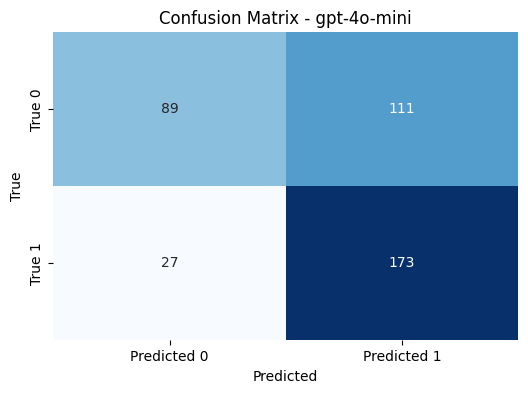

gpt-4o: recall: 0.8000, precision: 0.6275, f1: 0.7033, Cohen's Kappa: 0.3250, avg_latency: 1.6368




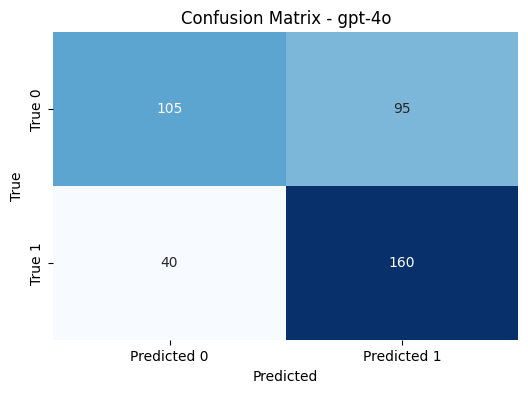

snowflake-arctic: recall: 0.9300, precision: 0.5741, f1: 0.7099, Cohen's Kappa: 0.2400, avg_latency: 2.3816




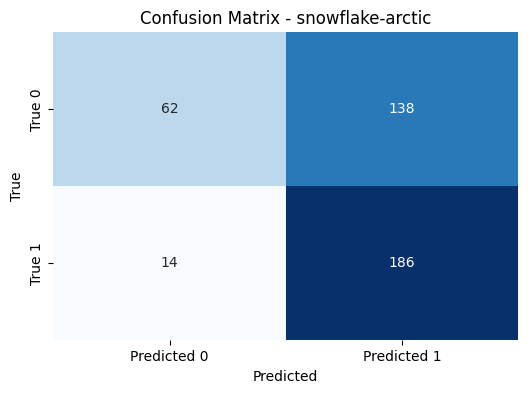

llama3.1-8b: recall: 0.9650, precision: 0.5710, f1: 0.7175, Cohen's Kappa: 0.2400, avg_latency: 5.1339




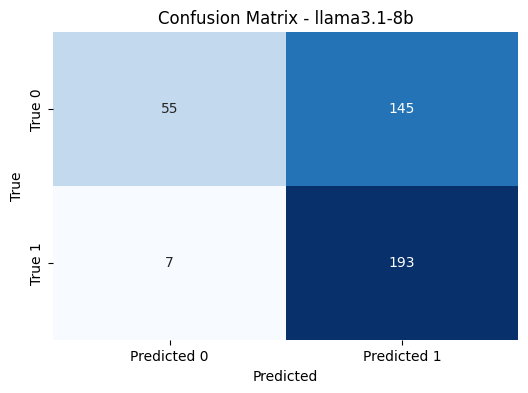

mistral-large: recall: 0.8550, precision: 0.6310, f1: 0.7261, Cohen's Kappa: 0.3550, avg_latency: 2.7201




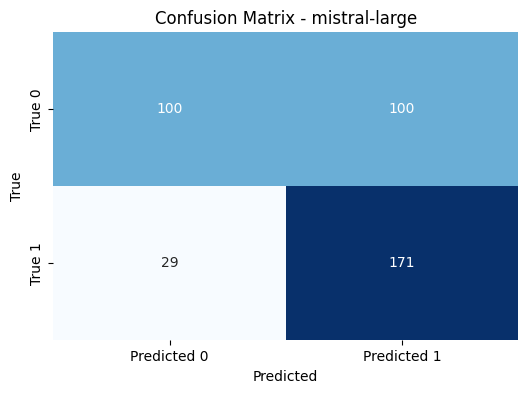

In [8]:
from trulens.feedback import GroundTruthAggregator

for provider_name in [
    "gpt-4o-mini",
    "gpt-4o",
    "snowflake-arctic",
    "llama3.1-8b",
    "mistral-large",
]:
    file_path = f"/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/results/MS MARCO hard negatives (first 400 samples) - {provider_name}_context_relevance_binary_results.csv"
    scores, labels, latencies = read_results(file_path)
    f_recall = GroundTruthAggregator(labels).recall
    f_precision = GroundTruthAggregator(labels).precision
    f_f1_score = GroundTruthAggregator(labels).f1_score

    binary_labels = []
    for label in labels:
        if label >= 0.5:
            binary_labels.append(1)
        else:
            binary_labels.append(0)

    f_cohens_kappa = GroundTruthAggregator(binary_labels).cohens_kappa
    f_auc = GroundTruthAggregator(labels).auc

    f_mae = GroundTruthAggregator(labels).mae
    f_pearson = GroundTruthAggregator(labels).pearson_correlation
    f_spearman = GroundTruthAggregator(labels).spearman_correlation

    recall = f_recall(scores)
    precision = f_precision(scores)
    f1_score = f_f1_score(scores)
    mae = f_mae(scores)
    pearson = f_pearson(scores)
    spearman = f_spearman(scores)
    cohens_kappa = f_cohens_kappa(scores)
    # auc = f_auc(scores)

    for latency in latencies:
        if latency > 20:
            # print(f"Warning: latency is greater than 10 seconds: {latency}")
            latencies.remove(latency)
    avg_latency = sum(latencies) / len(latencies)

    # print(f"{provider_name}: mae: {mae:.4f}, pearson: {pearson:.4f}, spearman: {spearman:.4f}, Cohen's Kappa: {cohens_kappa:.4f}")
    print(
        f"{provider_name}: recall: {recall:.4f}, precision: {precision:.4f}, f1: {f1_score:.4f}, Cohen's Kappa: {cohens_kappa:.4f}, avg_latency: {avg_latency:.4f}"
    )
    print("\n")
    
    plot_confusion_matrix(labels, scores, title=f"Confusion Matrix - {provider_name}")

In [11]:
cortex_eval_df = pd.read_csv("/Users/dhuang/Documents/git/trulens/src/benchmark/trulens/benchmark/benchmark_frameworks/experiments/eval_scrape_mistral-large_output_1727118011.csv")

In [14]:
cortex_eval_df.columns

Index(['query', 'expected_response', 'golden', 'context_file',
       'rephrased_queries', 'session', 'llm_answer', 'adjusted_llm_answer',
       'rag_context', 'input_token_count', 'debug_signals', 'citations',
       'rewritten_queries', 'accuracy_llm', 'llm_judge_answer',
       'llm_citation_f1', 'llm_response_citation', 'llm_judge', 'search_table',
       'is_match', 'anls', 'citation_match', 'citation_syntax',
       'citation_error', 'citation_specific_reason', 'citation_precision',
       'gt_citation_f1', 'gris_anls', 'retrieval_anls', 'retrieval_ndcg_at_1',
       'retrieval_hit_at_1', 'retrieval_ndcg_at_3', 'retrieval_hit_at_3',
       'gris_llm_answer'],
      dtype='object')

In [121]:
from trulens.providers.openai import OpenAI

gpt_4o = OpenAI(model_engine="gpt-4o-mini")

context_relevant_likert_4_criteria = """
        - CONTEXT that is IRRELEVANT to the QUESTION should score 0.
        - CONTEXT that is RELEVANT to some of the QUESTION should score of 1.
        - CONTEXT that is RELEVANT to most of the QUESTION should get a score of 2.
        - CONTEXT that is RELEVANT to the entirety of the QUESTION should get a score of 3, which is the full mark.
        - CONTEXT must be relevant and helpful for answering the entire QUESTION to get a score of 3.
        """
def trulens_context_relevance(query, context) -> float:
    try:
        return gpt_4o.context_relevance_with_cot_reasons(
                question=query,
                context=context,
                max_score_val=3,
                min_score_val=0,
                criteria=context_relevant_likert_4_criteria
        )[0]
    except Exception as e:
        print(f"Error in trulens_context_relevance: {e}")
        return -1
answer_relevant_likert_4_criteria = """
        - RESPONSE must be relevant to the entire PROMPT to get a score of 4.
        - RELEVANCE score should increase as the RESPONSE provides RELEVANT context to more parts of the PROMPT.
        - RESPONSE that is RELEVANT to none of the PROMPT should get a score of 0.
        - RESPONSE that is RELEVANT to some of the PROMPT should get as score of 1 or 2. Higher score indicates more RELEVANCE.
        - RESPONSE that is RELEVANT to the entire PROMPT should get a score of 3.
        - RESPONSE that is RELEVANT and answers the entire PROMPT completely should get a score of 3.
        - RESPONSE that confidently FALSE should get a score of 0.
        - RESPONSE that is only seemingly RELEVANT should get a score of 0.
        - Answers that intentionally do not answer the question, such as 'I don't know' and model refusals, should also be counted as the least RELEVANT and get a score of 0.
    """
def trulens_answer_relevance(query, response) -> float:
    try:
        return gpt_4o.relevance(
                prompt=query,
                response=response,
                min_score_val=0,
                max_score_val=3,
                criteria=answer_relevant_likert_4_criteria
        )
    except Exception as e:
        print(f"Error in trulens_answer_relevance: {e}")
        return -1

def trulens_answer_relevance_cot(query, response) -> float:
    try:
        return gpt_4o.relevance_with_cot_reasons(
                prompt=query,
                response=response,
                min_score_val=0,
                max_score_val=3,
                criteria=answer_relevant_likert_4_criteria
        )[0]
    except Exception as e:
        print(f"Error in trulens_answer_relevance: {e}")
        return -1

likert4_groundedness_criteria = """You should score the groundedness of the statement based on the following criteria:
    - Statements that are directly supported by the source should be considered grounded and should get a high score.
    - Statements that are not directly supported by the source should be considered not grounded and should get a low score.
    - Statements of doubt, that admissions of uncertainty or not knowing the answer are considered abstention, and should be counted as the most overlap and therefore get a max score."""
def trulens_groundedness(context, response) -> float:
    try:
        return gpt_4o.groundedness_measure_with_cot_reasons(
                source=context,
                statement=response,
                use_sent_tokenize=True,
                min_score_val=0,
                max_score_val=3,
                criteria=likert4_groundedness_criteria,
        )[0]
    except Exception as e:
        print(f"Error in trulens_groundedness: {e}")
        return -1
        
context_relevance_scores, answer_relevance_scores, groundedness_scores, answer_relevance_cot_scores = [], [], [], []

for i, row in cortex_eval_df.iterrows():
    query = row["query"]
    context_chunks = [chunk for chunk in ast.literal_eval(row["golden"])]
    llm_response = row["llm_answer"]
    
    assert query and llm_response, "query and llm_response should not be empty"

    print(f"ROW {i}: query: {query}\n , llm_response: {llm_response}\ng, context_chunks: {context_chunks} \n\n")
    answer_relevance_score = trulens_answer_relevance(query, llm_response)
    answer_relevance_cot_score = trulens_answer_relevance_cot(query, llm_response)
    answer_relevance_scores.append(answer_relevance_score)
    answer_relevance_cot_scores.append(answer_relevance_cot_score)
    if len(context_chunks) > 0:
        _context_relevance_scores_per_query = []
        _groundedness_scores_per_query = []
        for context in context_chunks:
            if context == "Country Work-from-home budget (USD) Welcome period (mo)\nPoland $350 12 ":
                contex = "Country Work-from-home budget (USD) Welcome period in Poland $350 12"
            _context_relevance_scores_per_query.append(trulens_context_relevance(query, context))
            _groundedness_scores_per_query.append(trulens_groundedness(context, llm_response))
            
        context_relevance_scores.append(sum(_context_relevance_scores_per_query)/len(_context_relevance_scores_per_query))
        groundedness_scores.append(sum(_groundedness_scores_per_query)/len(_groundedness_scores_per_query))
    else:
        context_relevance_scores.append(0)
        groundedness_scores.append(0)
assert len(context_relevance_scores) == len(answer_relevance_scores) == len(groundedness_scores) == len(cortex_eval_df) == len(answer_relevance_cot_scores)

# save scores to csv
cortex_eval_df["context_relevance_scores"] = context_relevance_scores
cortex_eval_df["answer_relevance_scores"] = answer_relevance_scores
cortex_eval_df["groundedness_scores"] = groundedness_scores
cortex_eval_df["answer_relevance_scores_cot"] = answer_relevance_cot_scores
cortex_eval_df.to_csv("cortex_eval_df_with_trulens_scores_relevance_cot.csv", index=False)

ROW 0: query: What tool do I use to engage sales prospects
 , llm_response: You can use the Outreach Sales Engagement Platform to engage sales prospects 【†1†】.
g, context_chunks: ['Requesting Outreach Access The Outreach Sales Engagement Platform helps efficiently and effectively engage prospects to drive more pipeline and close more deals.'] 


ROW 1: query: How can I get grammarly
 , llm_response: You can request access to Grammarly in two ways: 1. Submit a request ticket using the Lift Self Service catalog item and select the appropriate role, or 2. Go to SnowBot and type “Grammarly Access”. Then, complete the “Grammarly Access Request” form. Once your request is processed, you will receive an email from Grammarly. Open the email and click on “Accept Invitation”, then download and add Grammarly to your Chrome browser 【†1†】 【†2†】.
g, context_chunks: ['Requesting Grammarly Access Grammarly is a cross-platform cloud-based writing assistant that reviews spelling, grammar, punctuation, c

Error removing trivial statements: invalid syntax (<string>, line 1). Proceeding with all statements.


ROW 3: query: What tool do I use to set up alerting list for slack?
 , llm_response: To set up an alerting list for Slack, you can use the Datadog app. Invite the Datadog app to a Slack channel and it will be added automatically. After setting up the Slack integration, type @slack in your notification message to see the available list of channels to send your notification to. 【†1†】
g, context_chunks: ['Setup your team slack channel/mailing list for Alerting 1. Invite the Datadog app to a Slack channel and it will be added automatically. 2. After setting up the Slack integration, type @slack in your notification message to see the available 2. After setting up the Slack integration, type @slack in your notification message to see the available list of channels to send your notification to. 3. Wrap the @username in < > in your monitor’s message template to @-notify the defined user,within Slack notifications. For example: @slack-Snowflake'] 


ROW 4: query: How can I set up my 2FA to aut

Error removing trivial statements: invalid character '【' (U+3010) (<string>, line 1). Proceeding with all statements.


ROW 15: query: Can I get a French keyboard
 , llm_response: The provided excerpts do not mention anything about getting a French keyboard. Therefore, I don't know the answer to that question.
g, context_chunks: [] 


ROW 16: query: I'm going on a personal trip to China. Can I bring my laptop?
 , llm_response: The provided excerpts do not contain information about taking your laptop on a personal trip to China. Therefore, I don't know the answer to that question.
g, context_chunks: ['China & High-Risk Country Travel Process. Do not bring your Snowflake corporate laptop with you.'] 


ROW 17: query: BI:MADf beyond identity error
 , llm_response: The error BI:MADf indicates that the Mac device does not have FileVault disk encryption enabled. To resolve this issue, enable FileVault on the Mac device 【†1†】.
g, context_chunks: ['Mac device does not have FileVault disk encryption enabled. Enable FileVault. https://lift.snowflake.com/shorturl.do?\nnumber=KB0014839'] 


ROW 18: query: email ret

Error removing trivial statements: invalid syntax (<string>, line 1). Proceeding with all statements.


ROW 43: query: I lost my device with okta verify. What do I do?
 , llm_response: If you do not have access to the device that is currently setup with Okta Verify, you should reach out to the IT team in #team-it in Slack to have a tech manually reset it for you. They will need to verify your identity by calling you and asking you some questions before resetting 【†2†】. If you are completely locked out of Slack, Gmail and Service Portal, you can open a ticket from your personal email by emailing servicedesk@snowflake.com 【†2†】.
g, context_chunks: ["If you DO NOT have access to the device that is currently setup with Okta Verify, you\nprobably won't be able to login to the Service Portal to open a ticket, so please reach out to us in\n#team-it (https://snowflake.slack.com/archives/C4X35RJ2F) in Slack to have a tech manually\nreset it for you.\n1.IT will need to verify your identity by calling you and asking you some questions before\nresetting.\n2. If you are completely locked out of Slack

Error removing trivial statements: invalid syntax (<string>, line 1). Proceeding with all statements.


ROW 52: query: How do I print to a toshiba printer?
 , llm_response: To print to a Toshiba printer, follow these steps: Open the Self Service Application on your laptop and click on Toshiba Printer Driver. Then, open System Preferences by clicking on the Apple icon, and select System Preferences. Go to Printers & Scanners, click the [+] below the printer list, then Add. Select the TOSHIBA TEC TODEBA e-STUDIO350SAC printer. If you already have the printer in your list but still cannot print to it, you will want to delete the printer and then add the printer again 【†1†】.
g, context_chunks: ['<image>'] 


ROW 53: query: Is setup for Ricoh printers different than for Toshiba printers?
 , llm_response: The provided excerpts do not specify the setup process for Toshiba printers, they only detail the setup for Ricoh and non-Ricoh printers. Therefore, it's unclear if the setup for Ricoh printers is different than for Toshiba printers 【†1†】 【†2†】 【†3†】.
g, context_chunks: ['**From the Toshiba K

In [123]:
cortex_eval_df['answer_relevance_scores'] - cortex_eval_df['answer_relevance_scores_cot']

0     0.000000
1     0.000000
2     0.000000
3     0.000000
4     0.000000
5     0.000000
6     0.000000
7     0.000000
8     0.000000
9     0.000000
10    0.000000
11    0.000000
12    0.000000
13    0.000000
14    0.333333
15    0.000000
16    0.000000
17   -0.333333
18    0.333333
19    0.000000
20    0.666667
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.000000
36    0.000000
37    0.000000
38    0.000000
39    0.000000
40    0.000000
41    0.000000
42    0.000000
43    0.000000
44    0.000000
45    0.000000
46    0.000000
47    0.000000
48    0.000000
49    0.000000
50    0.000000
51    0.000000
52    0.000000
53    0.000000
54    0.000000
55    0.000000
56    0.000000
57    0.000000
58   -0.333333
59    0.000000
dtype: float64

In [124]:
answer_relevance_mean = cortex_eval_df['answer_relevance_scores_cot'].mean() * 100
context_relevance_mean = cortex_eval_df['context_relevance_scores'].mean() * 100
groundedness_mean = cortex_eval_df['groundedness_scores'].mean() * 100

print(f"Answer Relevance Mean Score: {answer_relevance_mean:.2f}%")
print(f"Context Relevance Mean Score: {context_relevance_mean:.2f}%")
print(f"Groundedness Mean Score: {groundedness_mean:.2f}%")

Answer Relevance Mean Score: 73.89%
Context Relevance Mean Score: 68.33%
Groundedness Mean Score: 48.00%


### Correlation test with Cortex's GT based metrics
#### 
Cortex GT-based metrics:

accuracy_llm: {-1, 0, 1, 2}, llm_citation_f1 [-1, 1.0], gt_citation_f1 [-1, 1.0], gris_llm_answer [0.0, 1.0] <-> answer relevance, context relevance, and groundedness (Likert 4)

anls, gris_anls [0.0, 1.0] 
retrieval_ndcg_at_1 [0.0, 1.0], retrieval_hit_rate_at_1 BINARY, retrieval_ndcg_at_3 [0.0, 1.0], retrieval_hit_rate_at_3 BINARY <-> context relevance 

adjusted_llm_answer vs llm_answer?


In [60]:
cortex_eval_df.columns

Index(['query', 'expected_response', 'golden', 'context_file',
       'rephrased_queries', 'session', 'llm_answer', 'adjusted_llm_answer',
       'rag_context', 'input_token_count', 'debug_signals', 'citations',
       'rewritten_queries', 'accuracy_llm', 'llm_judge_answer',
       'llm_citation_f1', 'llm_response_citation', 'llm_judge', 'search_table',
       'is_match', 'anls', 'citation_match', 'citation_syntax',
       'citation_error', 'citation_specific_reason', 'citation_precision',
       'gt_citation_f1', 'gris_anls', 'retrieval_anls', 'retrieval_ndcg_at_1',
       'retrieval_hit_at_1', 'retrieval_ndcg_at_3', 'retrieval_hit_at_3',
       'gris_llm_answer', 'context_relevance_scores',
       'answer_relevance_scores', 'groundedness_scores'],
      dtype='object')

In [125]:
cortex_eval_df['context_relevance_scores_binary'] = cortex_eval_df['context_relevance_scores'].apply(lambda x: 1 if x >= 0.5 else 0)
cortex_eval_df['answer_relevance_scores_binary'] = cortex_eval_df['answer_relevance_scores_cot'].apply(lambda x: 1 if x >= 0.5 else 0)
cortex_eval_df['groundedness_scores_binary'] = cortex_eval_df['groundedness_scores'].apply(lambda x: 1 if x >= 0.5 else 0)

In [126]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
import scipy.stats as stats
from scipy.stats import spearmanr, pearsonr


# Calculate Matthews correlation coefficient for retrieval_hit_at_1 and context_relevance_scores_binary
mcc_hit_at_1_context_relevance = matthews_corrcoef(cortex_eval_df['retrieval_hit_at_1'], cortex_eval_df['context_relevance_scores_binary'])
cohens_kappa_context_relevance = cohen_kappa_score(cortex_eval_df['retrieval_hit_at_1'], cortex_eval_df['context_relevance_scores_binary'])
print(f"Matthews Correlation Coefficient (retrieval_hit_at_1 vs context_relevance_scores_binary): {mcc_hit_at_1_context_relevance:.4f}")
print(f"Cohen's Kappa (retrieval_hit_at_1 vs context_relevance_scores_binary): {cohens_kappa_context_relevance:.4f}")

# Calculate Matthews correlation coefficient for retrieval_hit_at_3 and context_relevance_scores_binary
mcc_hit_at_3_context_relevance = matthews_corrcoef(cortex_eval_df['retrieval_hit_at_3'], cortex_eval_df['context_relevance_scores_binary'])
cohens_kappa_context_relevance = cohen_kappa_score(cortex_eval_df['retrieval_hit_at_3'], cortex_eval_df['context_relevance_scores_binary'])
print(f"Matthews Correlation Coefficient (retrieval_hit_at_3 vs context_relevance_scores_binary): {mcc_hit_at_3_context_relevance:.4f}")
print(f"cohen's Kappa (retrieval_hit_at_3 vs context_relevance_scores_binary): {cohens_kappa_context_relevance:.4f}")

Matthews Correlation Coefficient (retrieval_hit_at_1 vs context_relevance_scores_binary): 0.5229
Cohen's Kappa (retrieval_hit_at_1 vs context_relevance_scores_binary): 0.5197
Matthews Correlation Coefficient (retrieval_hit_at_3 vs context_relevance_scores_binary): 0.5585
cohen's Kappa (retrieval_hit_at_3 vs context_relevance_scores_binary): 0.5522


In [127]:
cortex_eval_df['accuracy_llm_normalized'] = cortex_eval_df['accuracy_llm'].apply(lambda x: (x - 0)/2)

In [129]:
REAL_VALUED_COLS = ['accuracy_llm_normalized', 'llm_citation_f1', 'gt_citation_f1', 'gris_llm_answer', 'anls', 'gris_anls', 'retrieval_ndcg_at_3', 'retrieval_ndcg_at_1']

In [130]:

    
    
    
# Create a dictionary to store the results
results = {
    "Cortex GT-based metrics": [],
    "Spearman correlation with context_relevance_scores": [],
    "Spearman correlation with answer_relevance_scores": [],
    "Spearman correlation with groundedness_scores": []
}

# Calculate Spearman correlations and store them in the dictionary
for col_name in REAL_VALUED_COLS:
    spearman_corr_context, _ = spearmanr(cortex_eval_df[col_name].apply(lambda x: 0 if x == -1 else x), cortex_eval_df['context_relevance_scores'])
    
    spearman_corr_answer, _ = spearmanr(cortex_eval_df[col_name].apply(lambda x: 0 if x == -1 else x), cortex_eval_df['answer_relevance_scores_cot'])
    
    spearman_corr_groundedness, _ = spearmanr(cortex_eval_df[col_name].apply(lambda x: 0 if x == -1 else x), cortex_eval_df['groundedness_scores'])
    
    
    
    results["Cortex GT-based metrics"].append(col_name)
    results["Spearman correlation with context_relevance_scores"].append(spearman_corr_context)
    results["Spearman correlation with answer_relevance_scores"].append(spearman_corr_answer)
    results["Spearman correlation with groundedness_scores"].append(spearman_corr_groundedness)

# Convert the dictionary to a pandas DataFrame
results_df = pd.DataFrame(results)
results_df

/var/folders/wv/24wjftnn0jb2gk0_90cnrmmh0000gn/T/ipykernel_63290/2136958907.py:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr_context, _ = spearmanr(cortex_eval_df[col_name].apply(lambda x: 0 if x == -1 else x), cortex_eval_df['context_relevance_scores'])
/var/folders/wv/24wjftnn0jb2gk0_90cnrmmh0000gn/T/ipykernel_63290/2136958907.py:13: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr_answer, _ = spearmanr(cortex_eval_df[col_name].apply(lambda x: 0 if x == -1 else x), cortex_eval_df['answer_relevance_scores_cot'])
/var/folders/wv/24wjftnn0jb2gk0_90cnrmmh0000gn/T/ipykernel_63290/2136958907.py:15: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr_groundedness, _ = spearmanr(cortex_eval_df[col_name].apply(lambda x: 0 if x == -1 else x), cortex_eval_df['groundedness_scores'])


,Cortex GT-based metrics,Spearman correlation with context_relevance_scores,Spearman correlation with answer_relevance_scores,Spearman correlation with groundedness_scores
0,accuracy_llm_normalized,0.049536,-0.034905,0.241457
1,llm_citation_f1,0.009054,-0.133332,-0.016555
2,gt_citation_f1,NaN,NaN,NaN
3,gris_llm_answer,0.046310,-0.091365,0.223963
4,anls,-0.128156,-0.037991,0.057499
5,gris_anls,-0.093176,-0.088607,0.061236
6,retrieval_ndcg_at_3,0.618186,0.581630,0.567309
7,retrieval_ndcg_at_1,0.567153,0.600265,0.512126


In [77]:
from scipy.stats import spearmanr

x = [1., 2., 4., 3.]
y = [2., 4., 1., 3.]

rho, p_value = spearmanr(x, y)
print(f"Spearman correlation: {rho:.4f}")

Spearman correlation: -0.4000


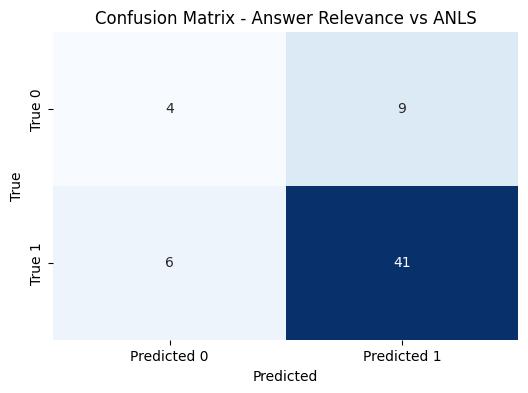

In [116]:
plot_confusion_matrix(cortex_eval_df['answer_relevance_scores_binary'], cortex_eval_df['anls'].apply(lambda x: 1 if x >= 0.5 else 0), title="Confusion Matrix - Answer Relevance vs ANLS")

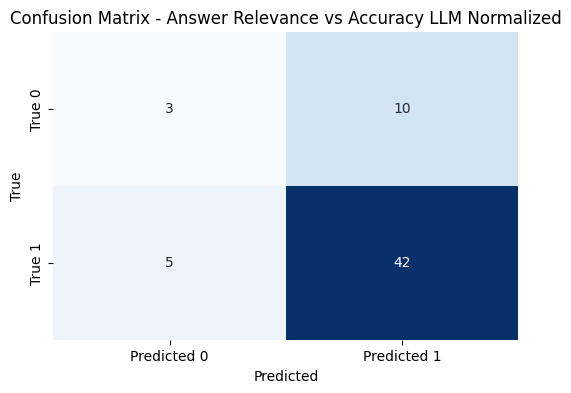

In [119]:
plot_confusion_matrix(cortex_eval_df['answer_relevance_scores_binary'], cortex_eval_df['accuracy_llm_normalized'].apply(lambda x: 1 if x >= 0.5 else 0), title="Confusion Matrix - Answer Relevance vs Accuracy LLM Normalized")